In [6]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 840.2 kB/s eta 0:00:11
   -- ------------------------------------- 0.5/9.6 MB 840.2 kB/s eta 0:00:11
   --- ------------------------------------ 0.8/9.6 MB 657.8 kB/s eta 0:00:14
   --- ------------------------------------ 0.8/9.6 MB 657.8 kB/s eta 0:00:14
   ---- ----------------------------------- 1.0/9.6 MB 699.0 kB/s eta 0:00:13
   ---- ----------------------------------- 1.0/9.6 MB 699.0 kB/s eta 0:00:13
   ----- ---------------------------------- 1.3/9.6 MB 671.3 kB/s eta 0:00:13
   ----- ---------------------------------- 1.3/9.6 MB 671.3 kB/s eta 0:00:13
   ------ --------------------------------- 1.6/9.6 MB 676.7 kB/s eta 0:00:12
   ------ ------------


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Deep Learning
import tensorflow as tf
from tensorflow import keras


In [26]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

In [27]:
df = pd.read_csv('data\DailyDelhiClimateTrain.csv')
dftest = pd.read_csv('data\DailyDelhiClimateTest.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [28]:
df.head(5)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [29]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)

dftest['date'] = pd.to_datetime(dftest['date'])
dftest = dftest.sort_values('date').reset_index(drop=True)
dftest.set_index('date', inplace=True)

In [30]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [31]:
date_diff = df.index.to_series().diff()
gaps = date_diff[date_diff > pd.Timedelta(days=1)]
print(f"\nDate gaps (>1 day): {len(gaps)}")
if len(gaps) > 0:
    print("\nGap locations:")
    print(gaps)


Date gaps (>1 day): 0


In [38]:
def outliers(data, column):
    if not np.issubdtype(data[column].dtype, np.number):
        return None, None, None
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

In [39]:
for col in df.columns:
    out, lower, upper = outliers(df, col)
    print(f"\n{col}:")
    print(f"  Lower bound: {lower:.2f}")
    print(f"  Upper bound: {upper:.2f}")
    print(f"  Number of outliers: {len(out)} ({len(out)/len(df)*100:.2f}%)")


meantemp:
  Lower bound: 0.18
  Upper bound: 49.98
  Number of outliers: 0 (0.00%)

humidity:
  Lower bound: 17.61
  Upper bound: 104.98
  Number of outliers: 2 (0.14%)

wind_speed:
  Lower bound: -5.17
  Upper bound: 17.88
  Number of outliers: 30 (2.05%)

meanpressure:
  Lower bound: 981.53
  Upper bound: 1034.99
  Number of outliers: 9 (0.62%)


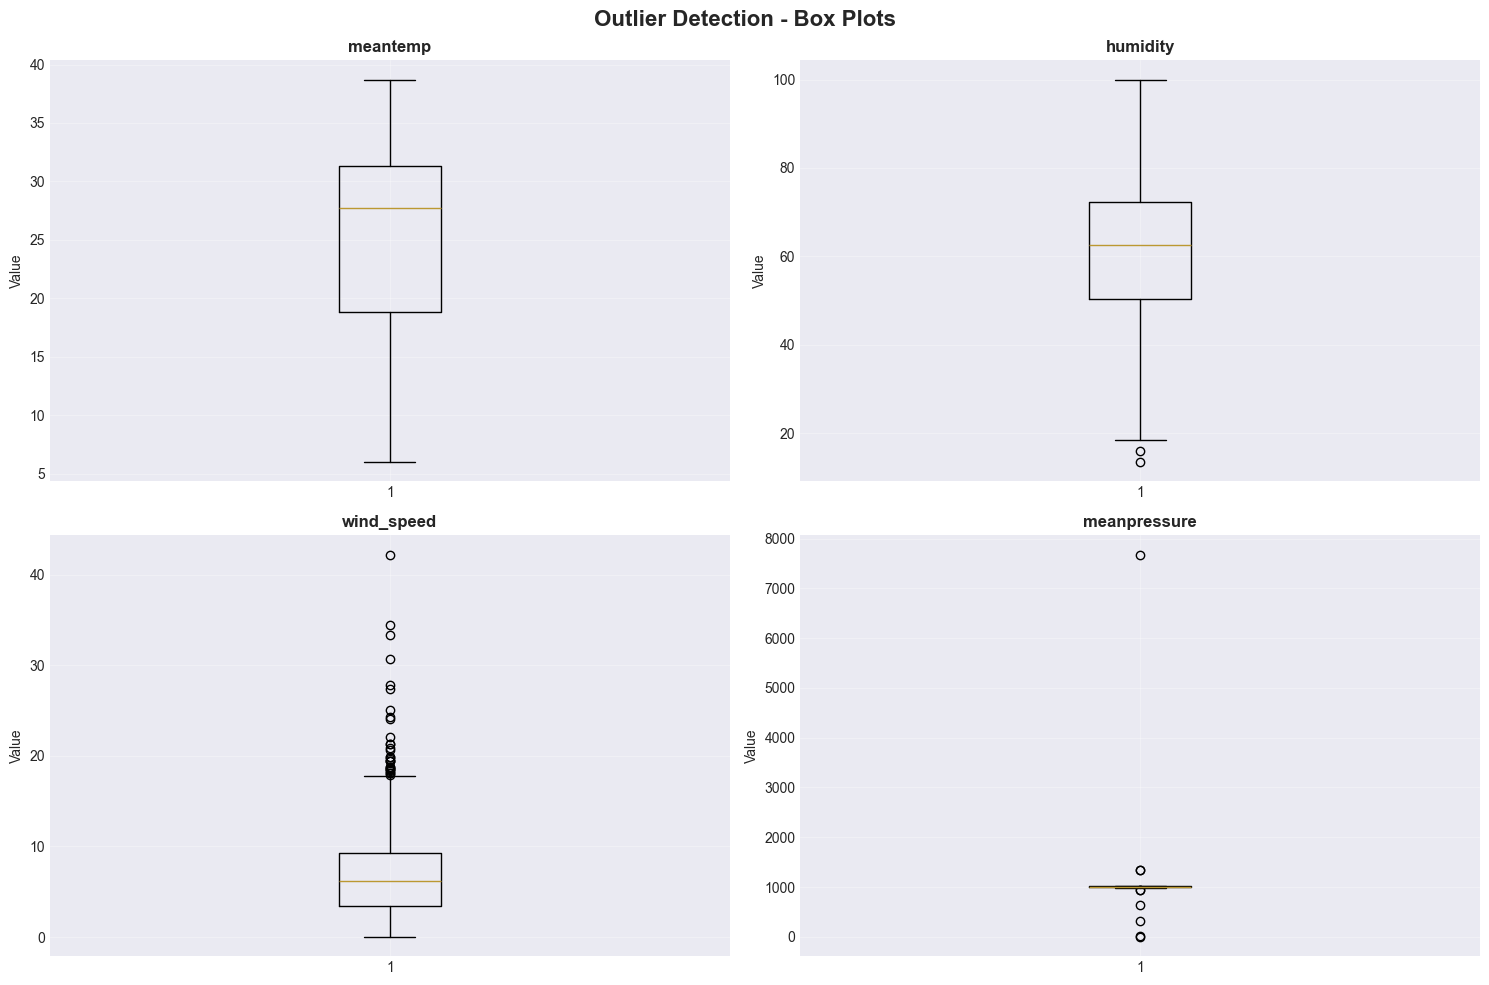

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Outlier Detection - Box Plots', fontsize=16, fontweight='bold')

for idx, col in enumerate(df.columns):
    row = idx // 2
    col_idx = idx % 2
    axes[row, col_idx].boxplot(df[col].dropna())
    axes[row, col_idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[row, col_idx].set_ylabel('Value')
    axes[row, col_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## step 2 visualization

2.1 time series plot fro all variables

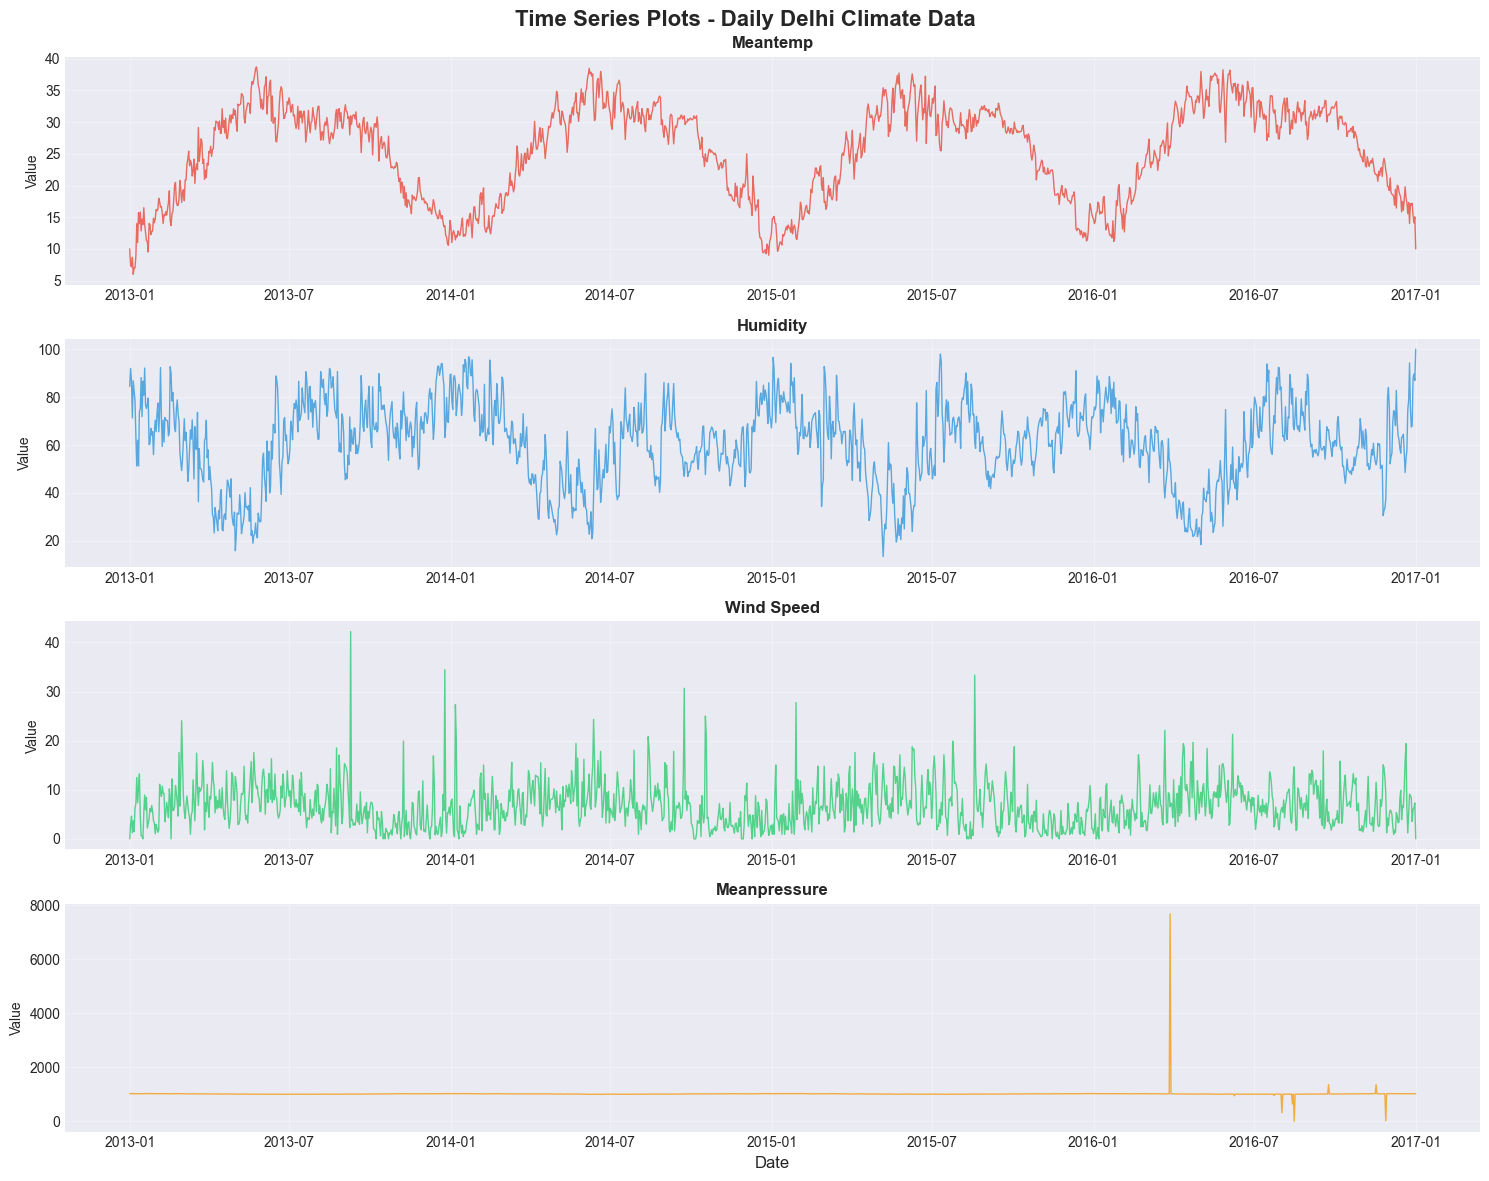

In [41]:
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Time Series Plots - Daily Delhi Climate Data', fontsize=16, fontweight='bold')

variables = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for idx, (var, color) in enumerate(zip(variables, colors)):
    axes[idx].plot(df.index, df[var], color=color, linewidth=1, alpha=0.8)
    axes[idx].set_title(f'{var.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)
    
axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

Detailed temperature plot with rolling averages

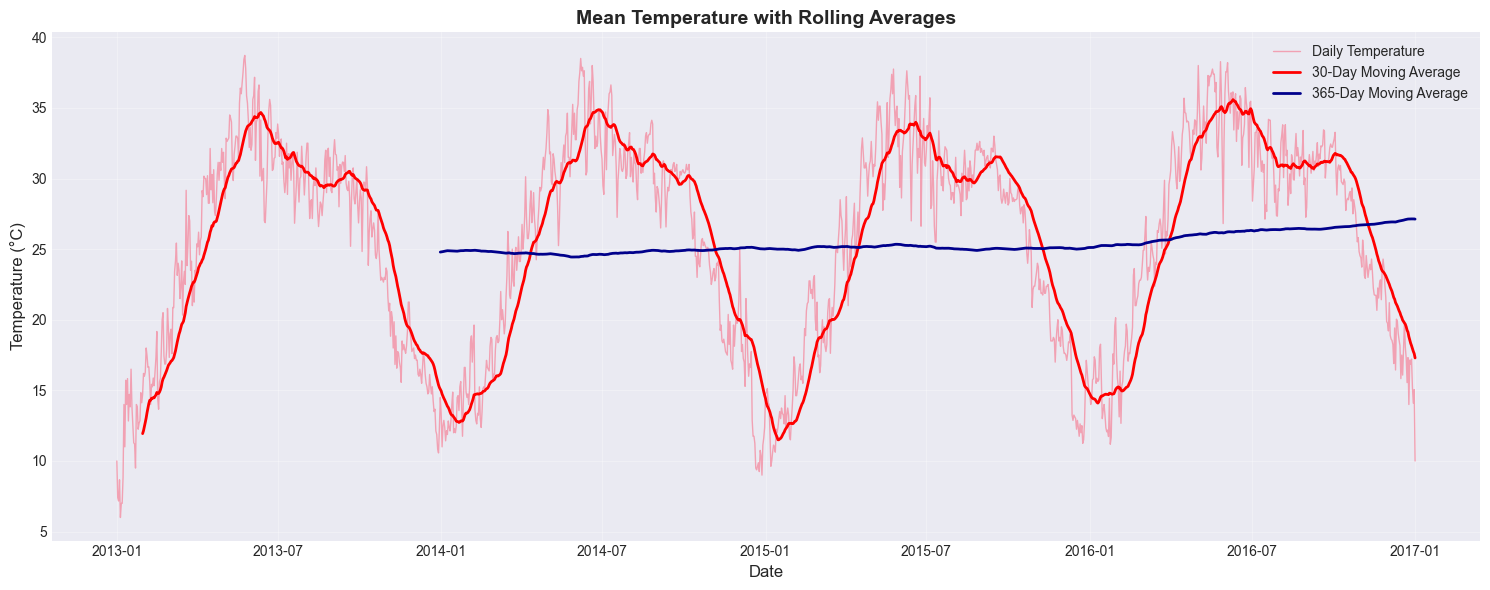

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df.index, df['meantemp'], label='Daily Temperature', alpha=0.6, linewidth=1)
ax.plot(df.index, df['meantemp'].rolling(window=30).mean(), 
        label='30-Day Moving Average', color='red', linewidth=2)
ax.plot(df.index, df['meantemp'].rolling(window=365).mean(), 
        label='365-Day Moving Average', color='darkblue', linewidth=2)

ax.set_title('Mean Temperature with Rolling Averages', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()